# Metropolis Hastings
Accomadating notebook to reproduce the experiments from the Bachelor's Thesis 'The Metropolis-Hastings algorithm for large datasets'

In [1]:
import matplotlib.pyplot as plt

import seaborn as sns
import numpy as np
import numpy.random as npr
import numpy.linalg as npl
import time
import multiprocessing as mp
from scipy.stats import norm

## Useful functions

In [2]:

#This function implements the subsampling methods used for the samples produced by MH
def create_sample(data, b, c):
    # Discard the first b of elements
    data = data[b:]

    # Select every c datapoint
    data = data[::c]

    return data

# Function to clean up acceptance probabilties
# Replace values bigger than 1 with 1
def clean_acceptance_probability(array):
    array = np.where(array > 1, 1, array)
    return array

/tmp/ipykernel_72470/4023198474.py:30: UserWarning: Ignoring `ax`; jointplot is a figure-level function.
  fig1 = sns.jointplot(ax = axes[0], x=dataset1[:, 0], y=dataset1[:, 1], kind='hex', cmap='Blues', alpha=1, space=0, gridsize=30, linewidths=0.5, edgecolors='white')
/tmp/ipykernel_72470/4023198474.py:32: UserWarning: Ignoring `ax`; jointplot is a figure-level function.
  fig2 = sns.jointplot(ax = axes[1], x=dataset2[:, 0], y=dataset2[:, 1], kind='hex', cmap='Blues', alpha=1, space=0, gridsize=30, linewidths=0.5, edgecolors='white')


AttributeError: 'Figure' object has no attribute '_make_key'

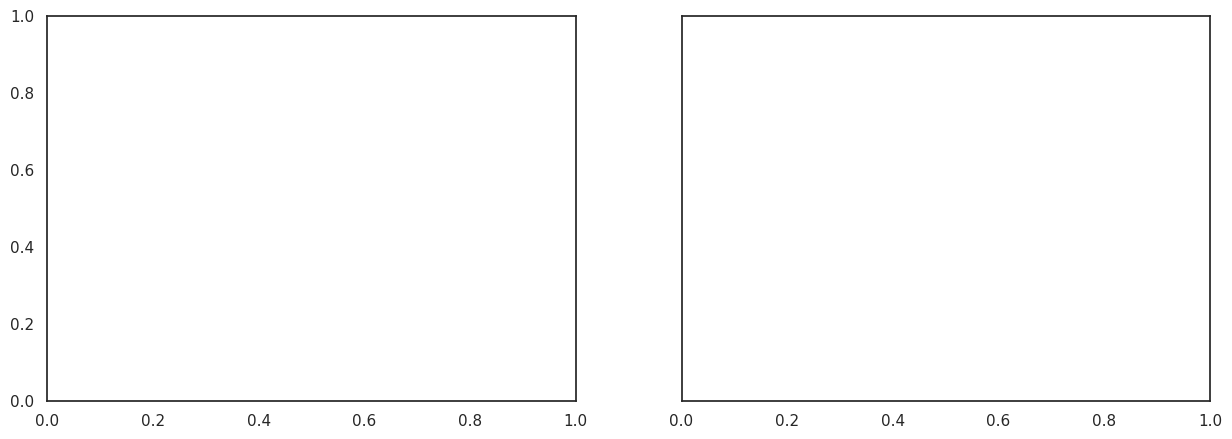

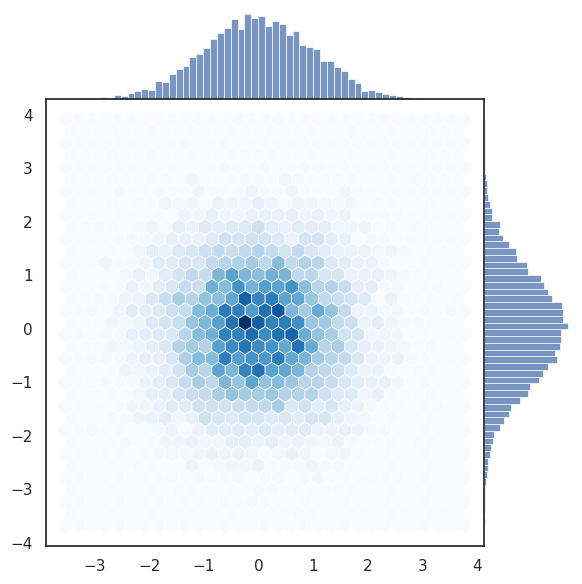

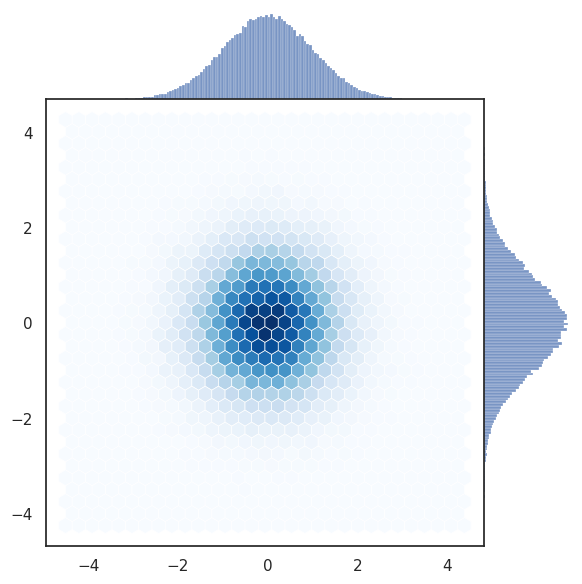

<Figure size 640x480 with 0 Axes>

In [15]:
def plt_samples(dataset):
    '''Plots the samples in a jointplot'''
    # Set the style of the plot
    xlimInf = np.min(dataset[:,0]) # Precompute limits for x and y plots
    xlimSup = np.max(dataset[:,0])
    xPlot = np.linspace(xlimInf, xlimSup, dataset.size)
    ylimInf = np.min((dataset[:,1]))
    ylimSup = np.max((dataset[:,1]))
    yPlot = np.linspace(ylimInf, ylimSup, dataset.size)

    sns.set_theme(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

    # Create a jointplot with smaller hexagons and aligned outlines
    g = sns.jointplot(x=dataset[:, 0], y=dataset[:, 1], kind='hex', cmap='Blues', alpha=1, space=0, gridsize=30, linewidths=0.5, edgecolors='white')

    # Remove the spines of the plot
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(True)
    plt.gca().spines['left'].set_visible(True)

    # Show the plot
    plt.show()
    return g

fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

dataset1 = npr.normal(size=(10000, 2))
dataset2 = npr.normal(size=(100000,2))
fig1 = sns.jointplot(ax = axes[0], x=dataset1[:, 0], y=dataset1[:, 1], kind='hex', cmap='Blues', alpha=1, space=0, gridsize=30, linewidths=0.5, edgecolors='white')

fig2 = sns.jointplot(ax = axes[1], x=dataset2[:, 0], y=dataset2[:, 1], kind='hex', cmap='Blues', alpha=1, space=0, gridsize=30, linewidths=0.5, edgecolors='white')


def plot_running_average(data, w):
    '''Plots the running average of a given array over a window of w iterations'''
    running_avg = np.convolve(data, np.ones(w), 'valid') / w
    plt.plot(running_avg)
    plt.xlabel('Iteration')
    plt.ylabel('Running Average ')
    plt.title('Running Average over a Window of {} Data Points'.format(w))
    plt.show()

def plot_acceptance_rate(array):
    plt.plot(array)
    plt.xlabel('Iteration')
    plt.ylabel('Acceptance Probability')
    plt.title('Acceptance Probability')
    plt.show()

In [ ]:
#
def sample_quality_score(sample, true_theta):
    '''Computes the quality score of a sample given the true theta'''
    # Compute the mean of the sample

    sample_mean = np.mean(sample, axis=0)
    mean_score = npl.norm(sample_mean - true_theta)

    sample_variance = np.std(sample)


    return mean_score, sample_variance

## Likelihood Functions

In [ ]:
#This cell implements all likelihood functions and their gradients for the different statistical models
class Normal_param_loglkhd():
    def __init__(self) -> None:
        pass

    def comp_func(self,data, theta):
        '''Return log_likelihood of mu, sigma of a normal distribution for given data'''
        mu = theta[0]
        sigma = theta[1]
        log_lkhd = -((data - mu) ** 2) / (2 * sigma**2) - np.log(sigma)
        return log_lkhd

    def comp_grad(self, data, theta):
        '''Return gradient of mu, sigma of a normal distribution for given data'''
        mu = theta[0]
        sigma = theta[1]
        grad_mu = np.mean((data - mu) / sigma**2)
        grad_sigma = np.mean(((data - mu) ** 2 - sigma**2) / sigma**3)
        grad = np.array([grad_mu, grad_sigma])
        return grad

    def comp_hess(self, data, theta):
        '''Return hessian of mu, sigma of a normal distribution for given data'''
        mu = theta[0]
        sigma = theta[1]
        hess_mu_mu = np.ones(data.size)*(-1)/sigma**2
        hess_mu_sig = (-2)*(data - mu)/sigma**3
        hess_sig_sig = (-3)*((data - mu) ** 2) / sigma**4 + 1/sigma**2
        hess = np.array([[hess_mu_mu, hess_mu_sig], [hess_mu_sig, hess_sig_sig]])
        return hess

    def comp_third_deriv(self, data, theta):
        mu = theta[0]
        sigma = theta[0]
        td_mu_mu_mu = np.zeros(data.size)
        td_mu_mu_sig = np.ones(data.size)*2/sigma**3
        td_mu_sig_sig = (6)*(data - mu)/sigma**4
        td_sig_sig_sig = (12)*((data - mu) ** 2) / sigma**5 - 2/sigma**3
        third_deriv = np.array([td_mu_mu_mu, td_mu_mu_sig, td_mu_sig_sig, td_sig_sig_sig])
        return  third_deriv

    def comp_log_bound_func(self, data, current_theta, proposal_theta, MAPs):
        thetaMAP = MAPs[0]
        lkhd_MAP = MAPs[1]
        grad_MAP = MAPs[2]
        hess_MAP = MAPs[3]
        h = current_theta - thetaMAP
        grad = np.dot(grad_MAP.T,h)
        hess = np.dot(np.dot(hess_MAP, h), h)
        #Compute min and max of data
        min_data = np.min(data)
        max_data = np.max(data)
        xMinusMuMax = np.max(np.abs([1, min_data - current_theta[0],max_data - current_theta[0], min_data - thetaMAP[0], max_data - thetaMAP[0], max_data - proposal_theta[0], min_data - proposal_theta[0]]))
        sigmaMin = min(current_theta[1], thetaMAP[1], proposal_theta[1])
        M = np.max(np.abs(self.comp_third_deriv(data, np.array([xMinusMuMax, sigmaMin]))))
        R = M/6*npl.norm(h)**2
        logB = lkhd_MAP + grad + hess + R
        return logB

#Test bounding function
#test_norm = Normal_param_loglkhd()
#test_data = npr.normal(size=(1000, 1))
#current= np.array([0,1])
#proposal = np.array([1,2])
#MAPs = [np.array([0.1,1.1]), 1, np.array([0,1]), np.array([[0,1],[0,1]])]
#print(test_norm.comp_log_bound_func(test_data, current, proposal, MAPs))

In [ ]:
class Bimodal_norm_param_loglkhd():

    def comp_func(self, data, theta):
            '''Return log_likelihood of mu1 (expected value of the first normal distribution), mu2 (expected value of the second normal distribution) and p (probability of the first normal distribution) of a bimodal normal distribution for given data'''
            mu_1 = theta[0]
            mu_2 = theta[1]
            p = 0.5
            lkhd_mu1 = np.exp((-((data - mu_1) ** 2)) / 2)
            lkhd_mu2 = np.exp((-((data - mu_2) ** 2)) / 2)
            log_lkhd = np.log(p * lkhd_mu1 + (1 - p) * lkhd_mu2)
            return log_lkhd

    def comp_grad(self, data, theta):
        mu_1 = theta[0]
        mu_2 = theta[1]
        p = 0.5
        denominator = (p * np.exp(-((data - mu_1) ** 2) / 2) + (1 - p) * np.exp(-((data - mu_2) ** 2) / 2))
        grad_mu1 = p*(data - mu_1)*np.exp(-((data - mu_1) ** 2) / 2) / denominator
        grad_mu2 = (1-p)*(data - mu_2)*np.exp(-((data - mu_2) ** 2) / 2) / denominator
        grad = np.array([grad_mu1, grad_mu2])
        return grad

    def comp_hess(self, data, theta):
        pass



#Test the likelihood function
#test_norm = Normal_param_loglkhd()
#data = np.array([1, 2, 3, 4, 5])
#print(test_norm.comp_func(data, np.array([0,1])))

In [ ]:
# This cell implements all proposal functions

class Gaussian_Random_Walk():
    def propose_sample(self, theta, stepsize):
        '''Propose a new sample using a Gaussian random walk proposal'''
        proposal = npr.normal(theta, stepsize, len(theta))
        return proposal

class Langevin_Sampler():
    def propose_sample(self, theta, stepsize, grad, gradient_scaler):
        '''Propose a new sample using a Langevin proposal'''
        proposal = npr.normal(theta + grad * gradient_scaler, stepsize, len(theta)) #TODO: Check if this is correct
        return proposal
    # Test samplers
#test_sampler = Gaussian_Random_Walk()
#print(test_sampler.propose_sample(np.array([0, 0]), 0.1))

## Running Examples

In [ ]:
npr.seed(1)
N = 10**5 # Number of data points

# Norm param dataset
normal_param_data = npr.normal(0, 1, N)
realMean = np.mean(normal_param_data)
realStd = np.std(normal_param_data)
normal_param_MAP = np.array([realMean, realStd])
#plt.hist(normal_param_data, bins=100)

# Bimodal norm param dataset
p =1/2
mu1 = 0
mu2 = 1
mu1_normal = npr.normal(mu1, 1, int(N*(p)))
mu2_normal = npr.normal(mu2, 1, int(N*(1-p)))
bimodal_data = np.concatenate((mu1_normal, mu2_normal))
print(bimodal_data)
npr.shuffle(bimodal_data)
#plt.hist(bimodal_data, bins=100)


[-2.25211836  0.60568705  1.18338458 ...  1.83363722  1.00373374
  1.77219844]


# Basic Alorithms

## vanillaMH

In [ ]:
def vanillaMH(data, lkhd_function, proposal_function, initial_theta, num_iterations, stepsize, lkhd_scaler = 1):
    '''Return samples, acceptance probability, likelihoods,  of vanilla MH algorithm'''
    # Initialize variables
    acceptence_prob = np.empty(num_iterations-1)
    accepted = np.empty(num_iterations-1)
    lkhd_diff = np.empty(num_iterations-1)
    samples = np.empty((num_iterations, initial_theta.size))
    samples[0] = initial_theta
    lkhd = np.empty(num_iterations)
    lkhd[0] = lkhd_scaler * np.sum(lkhd_function.comp_func(data, initial_theta))

    for i in range(num_iterations - 1):
        # Propose a new sample
        proposal = proposal_function.propose_sample(samples[i], stepsize)

        # Compute the acceptance probability
        lkhd_proposal = lkhd_scaler * np.sum(lkhd_function.comp_func(data, proposal))
        lkhd_diff[i] = lkhd_proposal - lkhd[i]
        acceptence_prob[i] = np.exp(lkhd_diff[i])

        # Accept or reject the proposal
        u = npr.rand()
        if u < acceptence_prob[i]:
            samples[i+1] = proposal
            lkhd[i+1] = lkhd_proposal
            accepted[i] = 1
        else:
            samples[i+1] = samples[i]
            lkhd[i+1] = lkhd[i]
            accepted[i] = 0


    return samples, accepted, acceptence_prob, lkhd, lkhd_diff

In [ ]:
# vanillaMH
# Parameters
data = normal_param_data
#data = bimodal_data
lkhd = Normal_param_loglkhd()
#lkhd = Bimodal_norm_param_loglkhd()
proposal = Gaussian_Random_Walk()
initial_theta = np.array([1,2])
num_iterations = 10**4
stepsize = 0.01
lkhd_scaler = 0.1

samples, accepted, acceptence_prob, lkhd, lkhd_diff = vanillaMH(data, lkhd, proposal, initial_theta, num_iterations, stepsize, lkhd_scaler)
print("SUCCESFULLY RAN vanillaMH")

SUCCESFULLY RAN vanillaMH


(7.001052659584623, 0.4969384802950631)


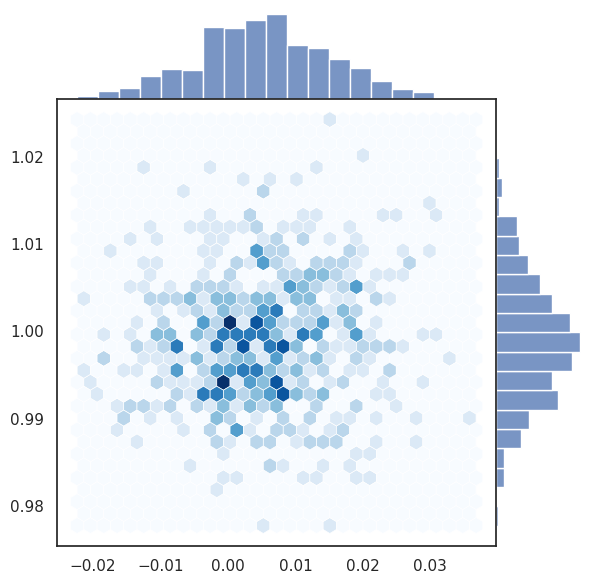

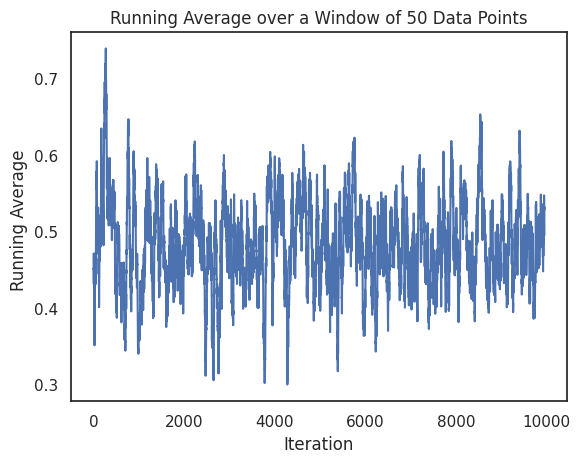

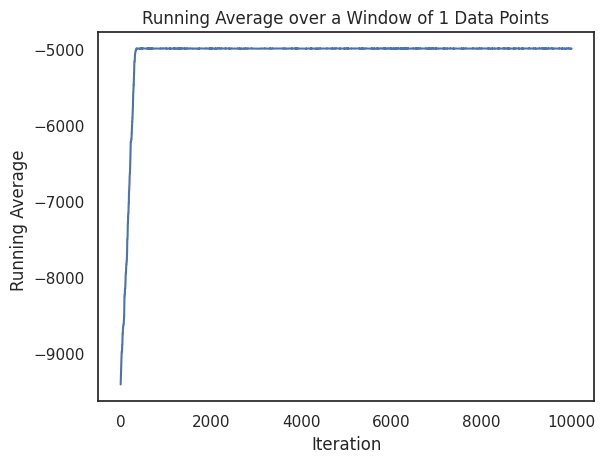

In [ ]:
plot_samples = create_sample(samples, 4000,10)
print(sample_quality_score(plot_samples, np.array([0,8])
                           ))

plt_samples(plot_samples)
acceptence_prob = clean_acceptance_probability(acceptence_prob)
plot_running_average(acceptence_prob, 50)
plot_running_average(lkhd, 1)

## MALA

In [ ]:
def mala(data, lkhd_function, proposal_function, initial_theta, num_iterations, stepsize, gradient_scaler, lkhd_scaler):
    '''Return samples, acceptance probability, likelihoods,  of vanilla MH algorithm'''
    # Initialize variables
    acceptence_prob = np.empty(num_iterations-1)
    accepted = np.empty(num_iterations-1)
    samples = np.empty((num_iterations, initial_theta.size))
    lkhd = np.empty(num_iterations)
    grad = np.empty((num_iterations, initial_theta.size))
    #Compute initial values
    samples[0] = initial_theta
    lkhd[0] = np.mean(lkhd_function.comp_func(data, initial_theta))
    print(lkhd_function.comp_grad(data, initial_theta))
    grad[0] = lkhd_function.comp_grad(data, initial_theta)

    for i in range(num_iterations - 1):
        # Propose a new sample
        proposal = proposal_function.propose_sample(samples[i], stepsize, grad[i], gradient_scaler)

        # Compute the acceptance probability
        lkhd_proposal = np.mean(lkhd_function.comp_func(data, proposal))
        grad_proposal = lkhd_function.comp_grad(data, proposal)
        diff_old = npl.norm(proposal - samples[i] - gradient_scaler*grad[i])**2
        diff_new = npl.norm(samples[i] - proposal - gradient_scaler*grad_proposal)**2
        lkhd_diff = (lkhd_proposal - lkhd[i])*lkhd_scaler
        acceptence_prob[i] = np.exp(lkhd_diff + (diff_old - diff_new) / (2*stepsize))

        # Accept or reject the proposal
        u = npr.rand()
        if u < acceptence_prob[i]:
            samples[i+1] = proposal
            lkhd[i+1] = lkhd_proposal
            grad[i+1] = grad_proposal
            accepted[i] = 1
        else:
            samples[i+1] = samples[i]
            lkhd[i+1] = lkhd[i]
            grad[i+1] = grad[i]
            accepted[i] = 0


    return samples, accepted, acceptence_prob, lkhd


In [ ]:
# MALA
# Parameters
data = bimodal_data
lkhd = Bimodal_norm_param_loglkhd()
proposal = Langevin_Sampler()
initial_theta = np.array([2,2])
num_iterations = 10**3
stepsize = 0.1
gradient_scaler = 1
lkhd_scaler = data.size*0.001

samples, accepted, acceptence_prob, lkhd = mala(data, lkhd, proposal, initial_theta, num_iterations, stepsize, gradient_scaler, lkhd_scaler)
print("SUCCESFULLY RAN MALA")

[[ 0.25359374 -0.49767576 -0.78346273 ... -0.67567534 -1.15301352
  -1.08090084]
 [ 0.25359374 -0.49767576 -0.78346273 ... -0.67567534 -1.15301352
  -1.08090084]]


ValueError: could not broadcast input array from shape (2,100000) into shape (2,)

(0.9995216920893425, 0.5144252696225905)


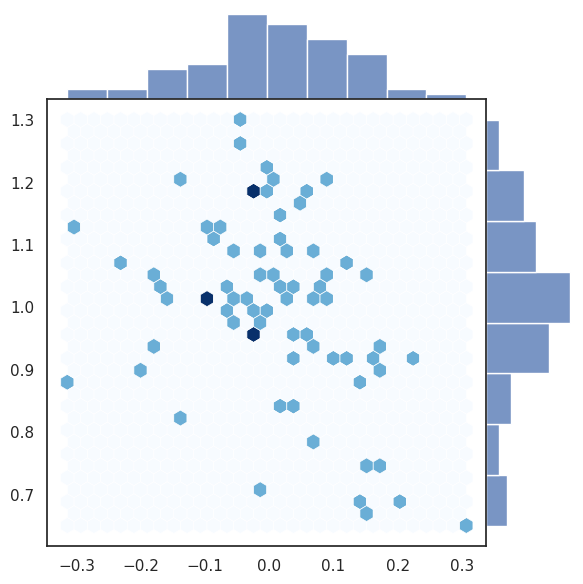

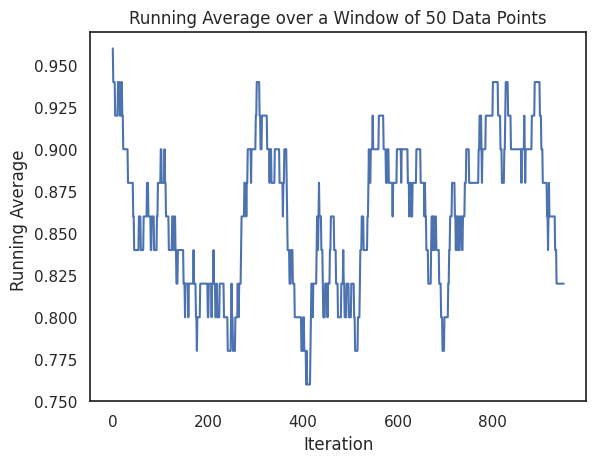

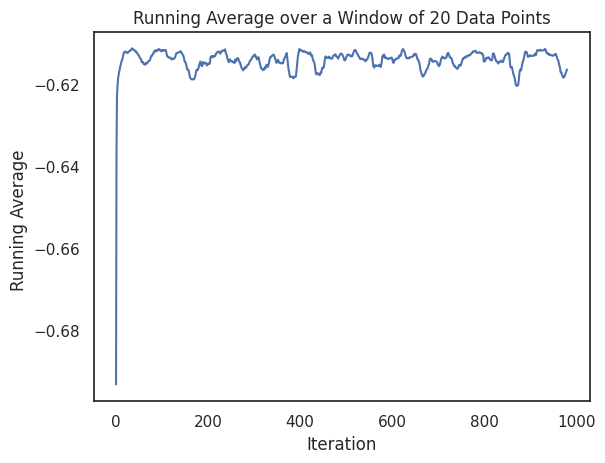

In [ ]:
plot_samples = create_sample(samples, 200,11)
print(sample_quality_score(plot_samples, np.array([0,2])))

plt_samples(plot_samples)
plot_running_average(accepted, 50)
plot_running_average(lkhd, 20)

# Scalable Adaptations

## consensusMC

In [ ]:
#Useful functions for consensusMC
def batch_divider(data, num_batches):
    '''Divide the data into random batches'''
    batch_size = data.size // num_batches  # Calculate batch size
    indices = npr.permutation(data.size) # Create shuffled indices
    batches = [indices[i*batch_size:(i+1)*batch_size] for i in range(num_batches)] # Split shuffled indices into batches
    batches_data = [data[batch] for batch in batches] # Extract batches from batches using shuffled indices
    return batches_data

#Test
#data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
#test = batch_divider(data, 3)
#print(test)

def batch_combiner(batch_sample_list):
    '''Combine the samples from the batches'''
    variance_list = [np.var(batch_sample) for batch_sample in batch_sample_list]
    sum_variances = np.sum(variance_list)
    weights = [variance / sum_variances for variance in variance_list]
    combined_samples = np.sum([weights[i] * batch_sample_list[i] for i in range(len(batch_sample_list))], axis=0)
    return combined_samples

#Test
#batch1 = np.array([[1, 2], [3, 4], [5,6]])
#batch2 = np.array([[6, 7], [8, 9], [10,11]])
#batch_sample_list = [batch1, batch2, batch2]
#test = batch_combiner(batch_sample_list)
#print(test)



In [ ]:
def consensusMC(data, lkhd_function, proposal_function, initial_theta, num_iterations, stepsize, num_batches, lkhd_scaler = 1):
    batches = batch_divider(data, num_batches)
    args = [(batch, lkhd_function, proposal_function, initial_theta, num_iterations, stepsize) for batch in batches] # List of arguments to run MH in parallel
    batch_list = []
    batch_sample_list = []
    for i in range(num_batches): # Parallel enviorenment
        #TODO: Make it parallel, save other returns from vanillaMH
        batch_list.append(vanillaMH(*args[i])) # Run MH
        batch_sample_list.append(batch_list[i][0])
        if i==0:
            samples, accepted, acceptence_prob, lkhd, lkhd_diff = vanillaMH(*args[i])

    sample = batch_combiner(batch_sample_list) # Combine samples returned by batches
    return sample, accepted, acceptence_prob, lkhd, lkhd_diff

In [ ]:
# consensusMC
# Parameters
data = normal_param_data
lkhd = Normal_param_loglkhd()
proposal = Gaussian_Random_Walk()
initial_theta = np.array([1,2])
num_iterations = 10**4
stepsize = 0.001
num_batches = 4
lkhd_scaler = 0.1

samples, accepted, acceptence_prob, lkhd, lkhd_diff = consensusMC(data, lkhd, proposal, initial_theta, num_iterations, stepsize, num_batches, lkhd_scaler)
print("SUCCESFULLY RAN consensusMC")

SUCCESFULLY RAN consensusMC


(0.00527155794412681, 0.49666838959038606)


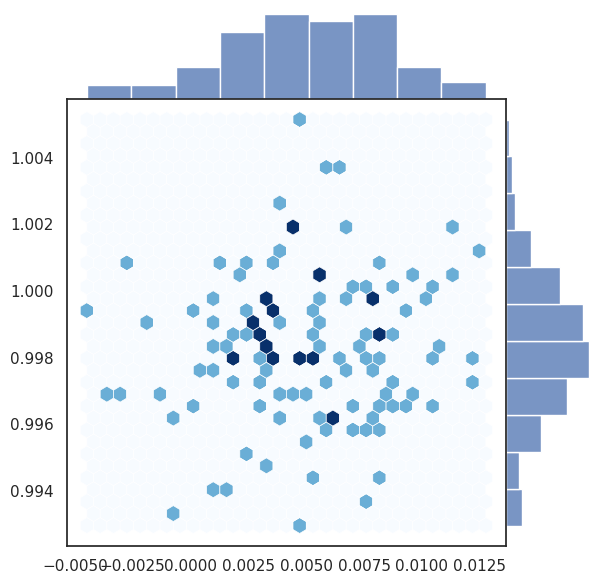

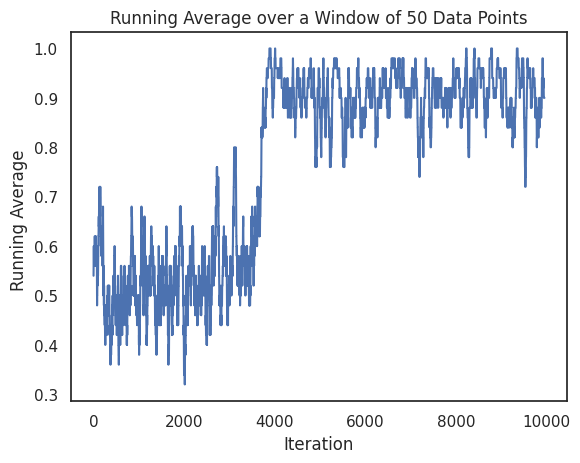

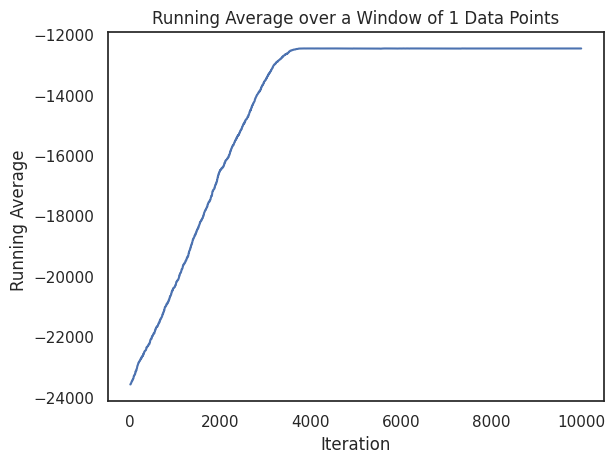

In [ ]:
plot_samples = create_sample(samples, 4000,50)
print(sample_quality_score(plot_samples, np.array([0,1])))

plt_samples(plot_samples)

plot_running_average(accepted, 50)
plot_running_average(lkhd, 1)


## csMALA

In [ ]:
#Useful functions csMALA

def bernoulli_sampling(data, sampling_perc):
    '''
    Subset dataset
    '''
    subsample_indx = npr.binomial(n=1,p=sampling_perc, size=data.size)
    subsample = data[subsample_indx == 1]
    return subsample

#Test
#array = np.arange(10000)
#test = bernoulli_sampling(array, 0.5)
#print(test)
#print(test.size)

In [ ]:
def csMALA(data, lkhd_function, proposal_function, initial_theta, num_iterations, stepsize, gradient_scaler, subsampling_perc, correction_scaler, lkhd_scaler):
    '''Return samples, acceptance probability, likelihoods,  of vanilla MH algorithm'''
    # Initialize variables
    acceptence_prob = np.empty(num_iterations-1)
    accepted = np.empty(num_iterations-1)
    samples = np.empty((num_iterations, initial_theta.size))
    lkhd_diff = np.empty(num_iterations- 1)
    corr_diff = np.empty(num_iterations- 1)
    prob_diff = np.empty(num_iterations- 1)
    lkhd = np.empty(num_iterations)
    grad = np.empty((num_iterations, initial_theta.size))
    correction_term = np.empty(num_iterations)
    log_subsampling_perc = np.log(subsampling_perc)
    #Compute initial values
    subsample = bernoulli_sampling(data, subsampling_perc)
    correction_term[0] = correction_scaler*log_subsampling_perc*len(subsample)*lkhd_scaler**(-1)
    samples[0] = initial_theta
    lkhd[0] = np.mean(lkhd_function.comp_func(subsample, initial_theta))
    grad[0] = lkhd_function.comp_grad(subsample, initial_theta)

    for i in range(num_iterations - 1):
        # Propose a new sample
        proposal = proposal_function.propose_sample(samples[i], stepsize, grad[i], gradient_scaler)
        #New subsample
        subsample = bernoulli_sampling(data, subsampling_perc)
        # Compute the acceptance probability
        correction_term_proposal = correction_scaler*log_subsampling_perc*len(subsample)*lkhd_scaler**(-1)
        lkhd_proposal = np.mean(lkhd_function.comp_func(subsample, proposal))
        grad_proposal = lkhd_function.comp_grad(subsample, proposal)
        diff_old = npl.norm(proposal - samples[i] - gradient_scaler*grad[i])**2
        diff_new = npl.norm(samples[i] - proposal - gradient_scaler*grad_proposal)**2
        lkhd_diff[i] = (lkhd_proposal - lkhd[i])*lkhd_scaler
        corr_diff[i] = correction_term_proposal - correction_term[i]
        prob_diff[i] = (diff_old - diff_new) / (2*stepsize)
        acceptence_prob[i] = np.exp(lkhd_diff[i] + corr_diff[i] + prob_diff[i])

        # Accept or reject the proposal
        u = npr.rand()
        if u < acceptence_prob[i]:
            samples[i+1] = proposal
            lkhd[i+1] = lkhd_proposal
            grad[i+1] = grad_proposal
            correction_term[i+1] = correction_term_proposal
            accepted[i] = 1
        else:
            samples[i+1] = samples[i]
            lkhd[i+1] = lkhd[i]
            grad[i+1] = grad[i]
            correction_term[i+1] = correction_term[i]
            accepted[i] = 0


    return samples, accepted, acceptence_prob, lkhd, lkhd_diff, corr_diff, prob_diff

In [ ]:
# csMALA
# Parameters
data = normal_param_data
lkhd = Normal_param_loglkhd()
proposal = Langevin_Sampler()
initial_theta = np.array([1,2])
num_iterations = 10**4
stepsize = 0.01
gradient_scaler = 0.1
subsampling_perc = 0.01
correction_scaler = 0.1
lkhd_scaler = data.size*0.001

samples, accepted, acceptence_prob, lkhd, lkhd_diff, corr_diff, prob_diff = csMALA(data, lkhd, proposal, initial_theta, num_iterations, stepsize, gradient_scaler, subsampling_perc, correction_scaler,lkhd_scaler)
print("SUCCESFULLY RAN csMALA")

SUCCESFULLY RAN csMALA


-0.4540231039971057
0.010424444936058317
(7.099795474919694, 0.48527200435416157)


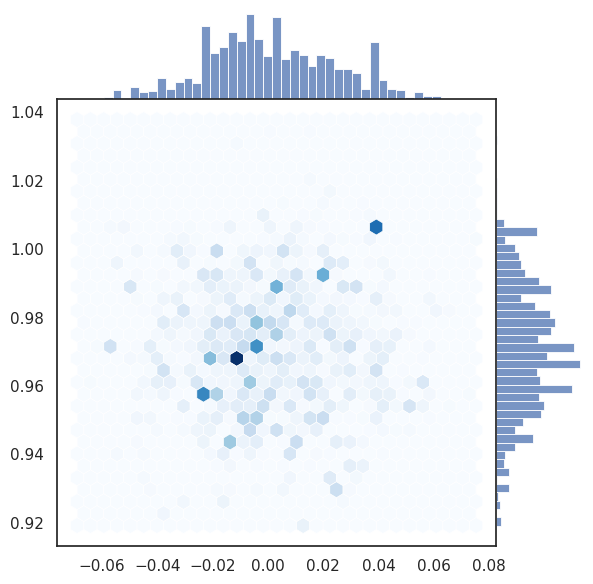

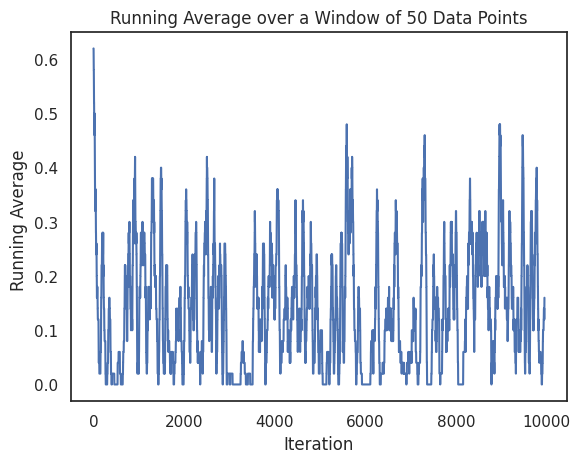

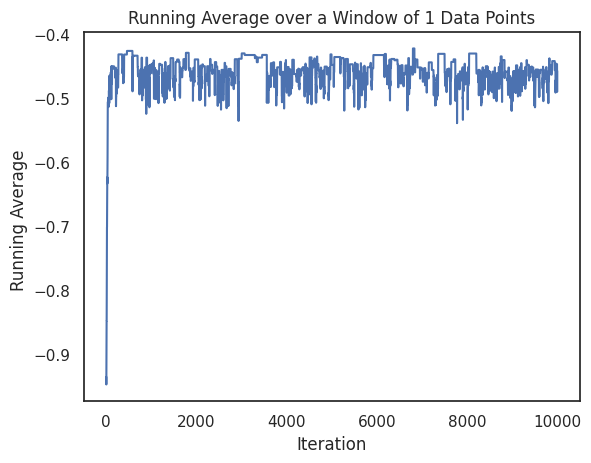

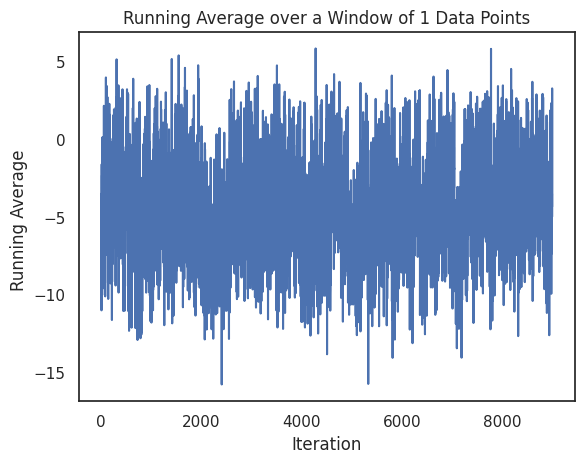

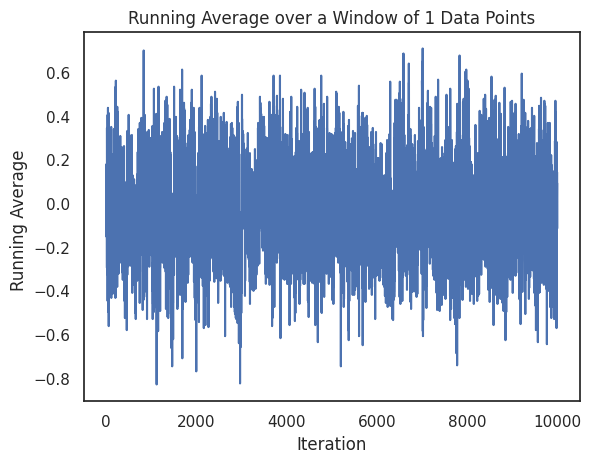

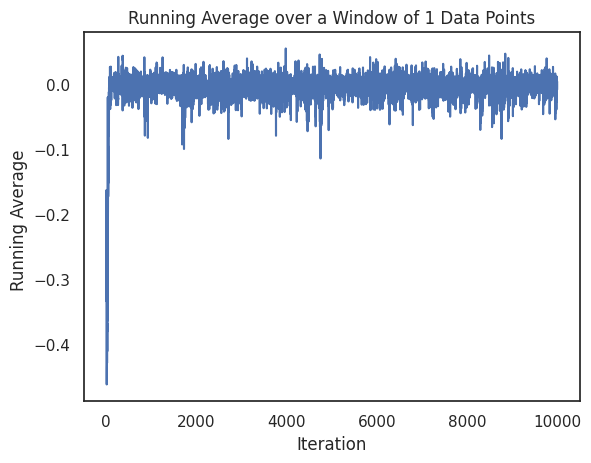

In [ ]:
print(np.median(lkhd))
print(np.median(acceptence_prob))

plot_samples = create_sample(samples, 1000,1)
lkhd_diff_sample = create_sample(lkhd_diff, 1000,1)
print(sample_quality_score(plot_samples, np.array([1,8])))

plt_samples(plot_samples)

plot_running_average(accepted,50)

plot_running_average(lkhd, 1)

plot_running_average(lkhd_diff_sample, 1)
plot_running_average(corr_diff, 1)
plot_running_average(prob_diff, 1)

## FireflyMC

In [ ]:
def firefly_sampler(data, current, proposal, lkhd_function, standard_subsampling_perc, MAPs):
    z = bernoulli_sampling(data, standard_subsampling_perc)
    logL = np.mean(lkhd_function.comp_func(z, current))
    logB = lkhd_function.comp_log_bound_func(z, current, proposal, MAPs)
    adaptive_subsampling_perc = 1 - np.exp(logB - logL)

    sample = bernoulli_sampling(z, adaptive_subsampling_perc)
    return sample, adaptive_subsampling_perc

def comp_firefly_joint_prob(data, subsample, theta, proposal, lkhd_function, MAPs):
    bounding_part = lkhd_function.comp_log_bound_func(data, theta, proposal, MAPs)
    logB = lkhd_function.comp_log_bound_func(subsample, theta, proposal, MAPs)
    logL = lkhd_function.comp_func(subsample, theta)
    adaptive_part = np.mean(np.log(np.exp(logL - logB) - 1))
    joint_prob = bounding_part + adaptive_part
    joint_prob = np.exp(joint_prob)
    return joint_prob

In [ ]:
def fireflyMC(data, lkhd_function, proposal_function, initial_theta, num_iterations, stepsize, subsampling_perc, thetaMAP):
    # Initialize variables
    acceptence_prob = np.empty(num_iterations-1)
    accepted = np.empty(num_iterations-1)
    samples = np.empty((num_iterations, initial_theta.size))
    samples[0] = initial_theta
    adaptive_sampling_perc = np.empty(num_iterations)
    adaptive_sampling_perc[0] = subsampling_perc
    #Initialize variables for bounding function
    lkhd_MAP = np.mean(lkhd_function.comp_func(data, thetaMAP))
    grad_MAP = lkhd_function.comp_grad(data, thetaMAP)
    hess_MAP = lkhd_function.comp_hess(data, thetaMAP)
    MAPs = [thetaMAP, lkhd_MAP, grad_MAP, hess_MAP]

    for i in range(num_iterations - 1):
        # Propose a new sample
        current = samples[i]
        proposal = proposal_function.propose_sample(current, stepsize)

        subsample, adaptive_sampling_perc[i] = firefly_sampler(data,  current, proposal, lkhd_function,subsampling_perc, MAPs)

        # Compute the acceptance probability
        joint_prob_curr = comp_firefly_joint_prob(data, subsample, current, proposal, lkhd_function, MAPs)
        joint_prob_prop = comp_firefly_joint_prob(data, subsample, proposal, current, lkhd_function, MAPs)
        acceptence_prob[i] = joint_prob_prop/joint_prob_curr

        # Accept or reject the proposal
        u = npr.rand()
        if u < acceptence_prob[i]:
            samples[i+1] = proposal
            accepted[i] = 1
        else:
            samples[i+1] = current
            accepted[i] = 0
    return samples, accepted, acceptence_prob

In [ ]:
# csMALA
# Parameters
data = normal_param_data
lkhd = Normal_param_loglkhd()
proposal = Gaussian_Random_Walk()
initial_theta = np.array([1,2])
num_iterations = 10**4
stepsize = 1
subsampling_perc = 0.01
lkhd_scaler = data.size*0.001
thetaMAP = np.array([np.mean(data),np.std(data)])

samples, accepted, acceptence_prob = fireflyMC(data, lkhd, proposal, initial_theta, num_iterations, stepsize, subsampling_perc, thetaMAP)
print("SUCCESFULLY RAN FireflyMC")

(22.868519747599652, 1.752449520611771)


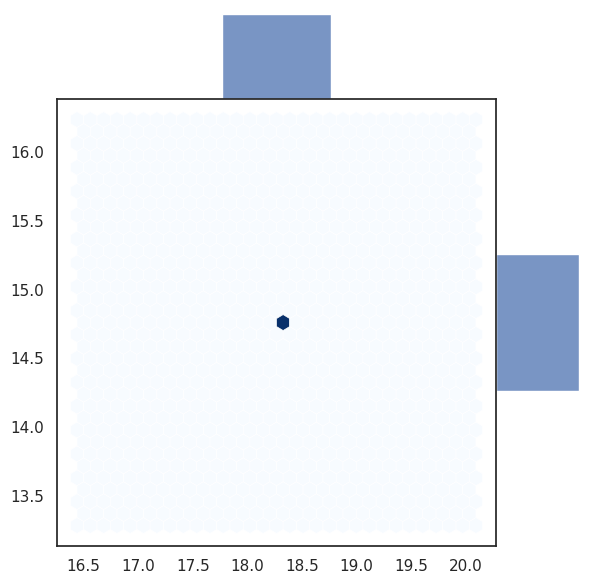

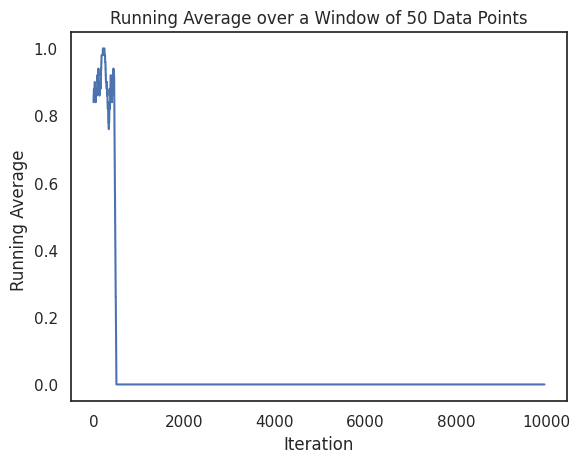

In [ ]:
plot_samples = create_sample(samples, 4000,5)
print(sample_quality_score(plot_samples, np.array([0,1])))

plt_samples(plot_samples)

plot_running_average(accepted, 50)

# Reproducible Results

## Standard Normal Model

In [ ]:
# Parameters
proposal_grw = Gaussian_Random_Walk()
proposal_langevin = Langevin_Sampler()

data_std = normal_param_data
lkhd_std = Normal_param_loglkhd()
initial_theta_std = np.array([1,2])
num_iterations_std = 10**4
gradient_scaler_std = 0.1
lkhd_scaler_std = data_std.size*0.001
subsampling_perc_std = 0.1

#Plotting params
burn_in_std = 4000
c_std = 10
true_theta_std = np.array([0,1])

### vanillaMH

SUCCESFULLY RAN vanillaMH
-499.08756222861524
0.9220524572918759
(0.002690285825482062, 0.5006058711063524)


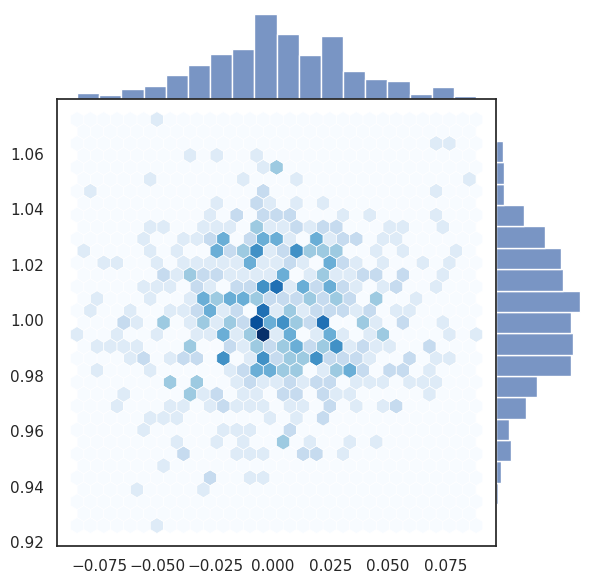

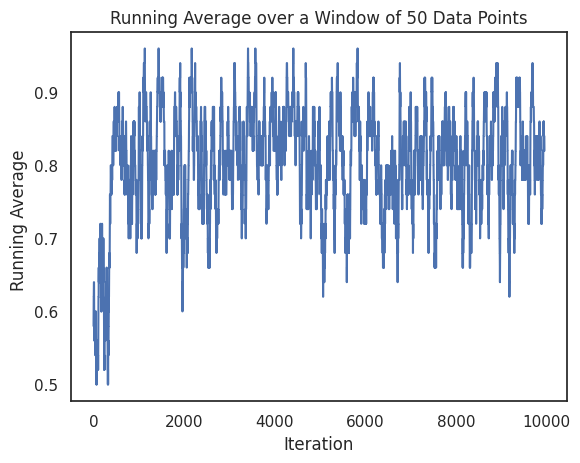

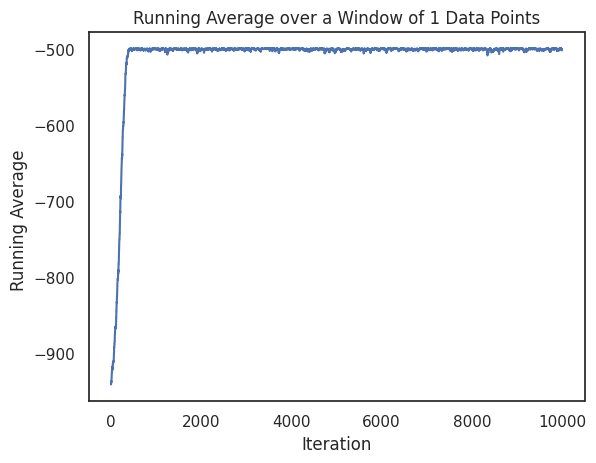

In [ ]:
stepsize_vanilla_std = 0.01
lkhd_scaler_vanilla_std = 0.01
samples, accepted, acceptence_prob, lkhd, lkhd_diff = vanillaMH(data_std, lkhd_std, proposal_grw, initial_theta_std, num_iterations_std, stepsize_vanilla_std, lkhd_scaler_vanilla_std)
print("SUCCESFULLY RAN vanillaMH")

print(np.median(lkhd))
print(np.median(acceptence_prob))

plot_samples = create_sample(samples, burn_in_std,c_std)
print(sample_quality_score(plot_samples, true_theta_std))

plt_samples(plot_samples)

plot_running_average(accepted,50)

plot_running_average(lkhd, 1)

### MALA


[-0.24868674 -0.25172714]
SUCCESFULLY RAN MALA
-0.5041139970090945
0.48926330284249164
(0.020803052144851657, 0.5081077872587478)


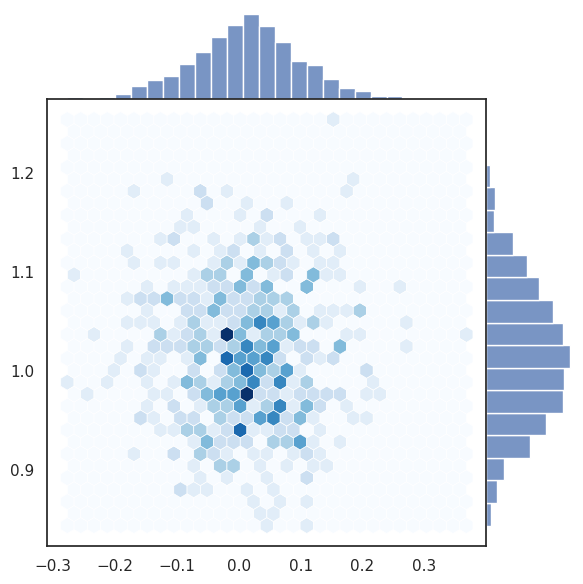

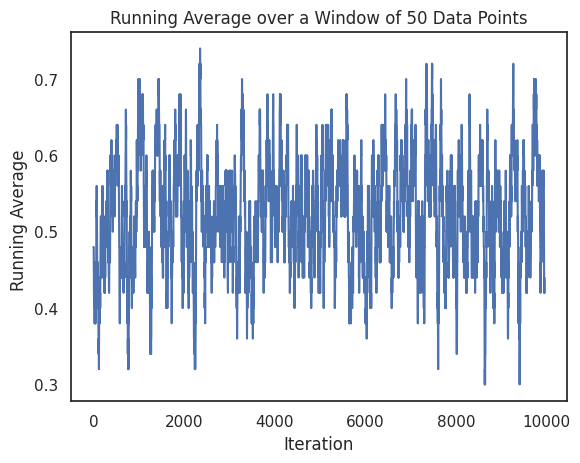

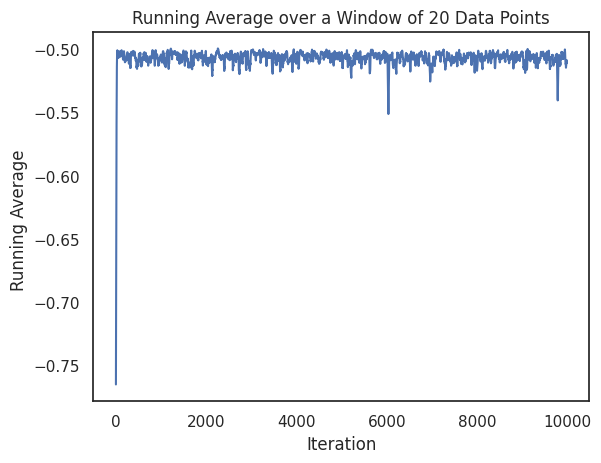

In [ ]:
stepsize_mala_std = 0.1
samples, accepted, acceptence_prob, lkhd = mala(data_std, lkhd_std, proposal_langevin, initial_theta_std, num_iterations_std, stepsize_mala_std, gradient_scaler_std, lkhd_scaler_std)
print("SUCCESFULLY RAN MALA")
print(np.median(lkhd))
print(np.median(acceptence_prob))

plot_samples = create_sample(samples, burn_in_std,c_std)
print(sample_quality_score(plot_samples, true_theta_std))

plt_samples(plot_samples)
plot_running_average(accepted, 50)
plot_running_average(lkhd, 20)

### consensusMC

/tmp/ipykernel_25077/31076570.py:19: RuntimeWarning: overflow encountered in exp
  acceptence_prob[i] = np.exp(lkhd_diff[i])


SUCCESFULLY RAN consensusMC
-6099.377262626562
3.4355018321403777e-56
(0.00544049953145429, 0.4964723203917163)


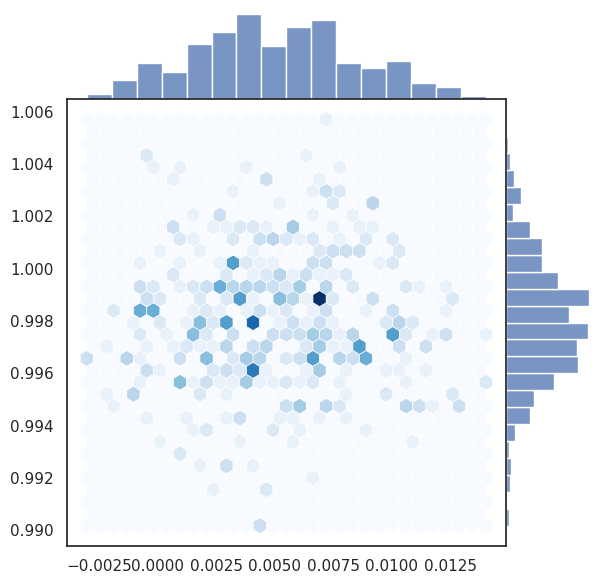

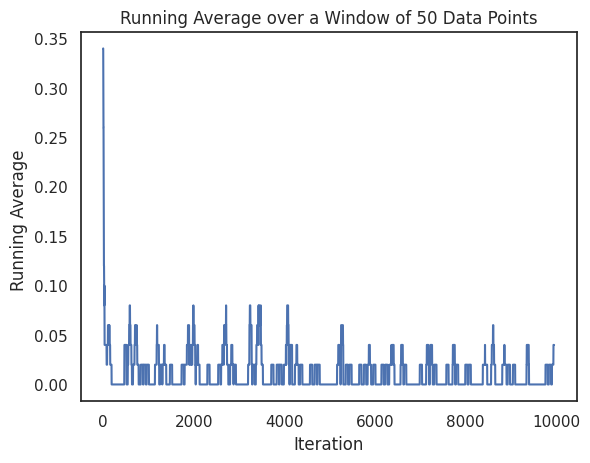

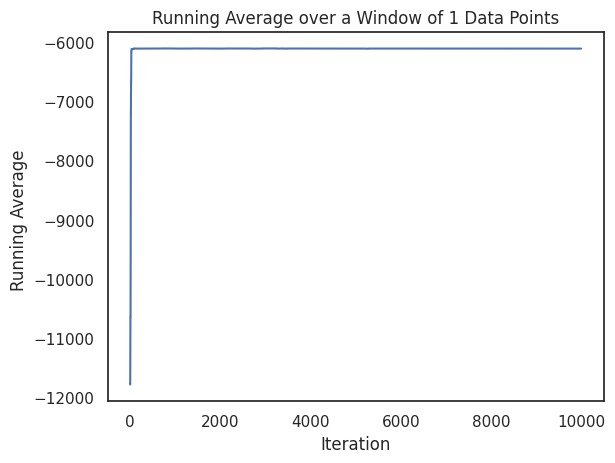

In [ ]:
stepsize_vanilla_std = 0.1
num_batches_std = 8
samples, accepted, acceptence_prob, lkhd, lkhd_diff = consensusMC(data_std, lkhd_std, proposal_grw, initial_theta_std, num_iterations_std, stepsize_vanilla_std, num_batches_std, lkhd_scaler_vanilla_std)
print("SUCCESFULLY RAN consensusMC")

print(np.median(lkhd))
print(np.median(acceptence_prob))

plot_samples = create_sample(samples, burn_in_std,c_std)
print(sample_quality_score(plot_samples, true_theta_std))

plt_samples(plot_samples)

plot_running_average(accepted,50)

plot_running_average(lkhd, 1)

### FireflyMC

### csMALA

SUCCESFULLY RAN csMALA
(0.010099639702702468, 0.510845824926807)


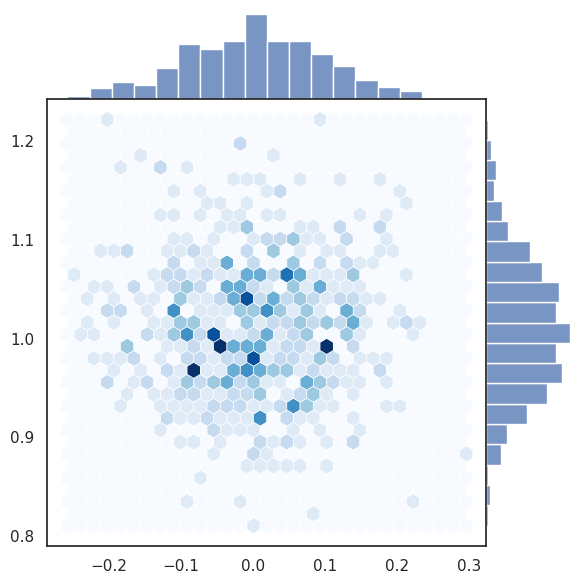

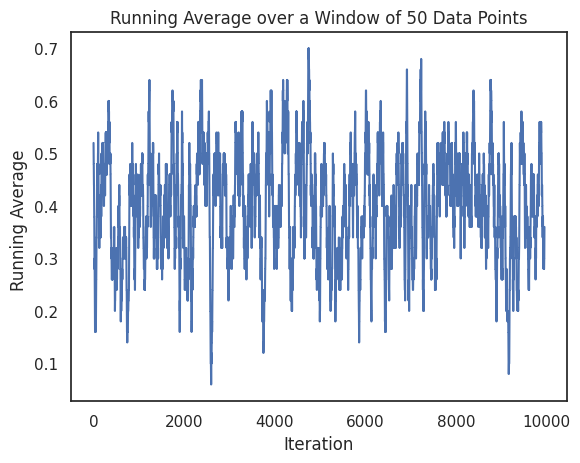

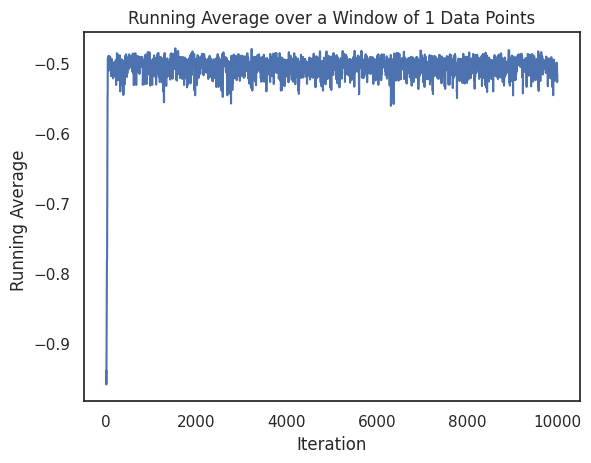

In [ ]:
correction_scaler_std = 0.1
lkhd_scaler_csMALA_std = data.size*0.001

samples, accepted, acceptence_prob, lkhd, lkhd_diff, corr_diff, prob_diff = csMALA(data_std, lkhd_std, proposal_langevin, initial_theta_std, num_iterations_std, stepsize_mala_std, gradient_scaler_std, subsampling_perc_std, correction_scaler_std,lkhd_scaler_csMALA_std)
print("SUCCESFULLY RAN csMALA")
plot_samples = create_sample(samples, burn_in_std,c_std)
print(sample_quality_score(plot_samples, true_theta_std))

plt_samples(plot_samples)

plot_running_average(accepted,50)

plot_running_average(lkhd, 1)

## Bimodal Model

In [ ]:
data_bi = bimodal_data
lkhd_bi = Bimodal_norm_param_loglkhd()
initial_theta_bi = np.array([0.5,0.5])
num_iterations_bi = 10**4
gradient_scaler_bi = 0.1
lkhd_scaler_bi = data_std.size*0.001
subsampling_perc_bi = 0.1

#Plotting params
burn_in_bi = 2000
c_bi = 2
true_theta_bi = np.array([0,1])

### vanillaMH

SUCCESFULLY RAN vanillaMH
-6.646528625559124
0.2649857673085004
(0.6929515362595259, 0.8702885363937052)


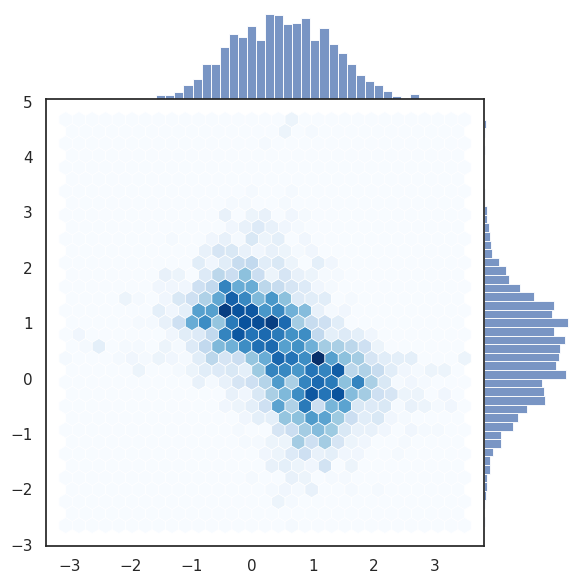

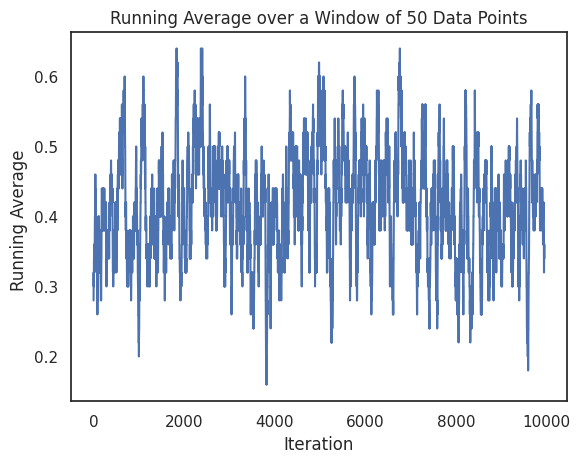

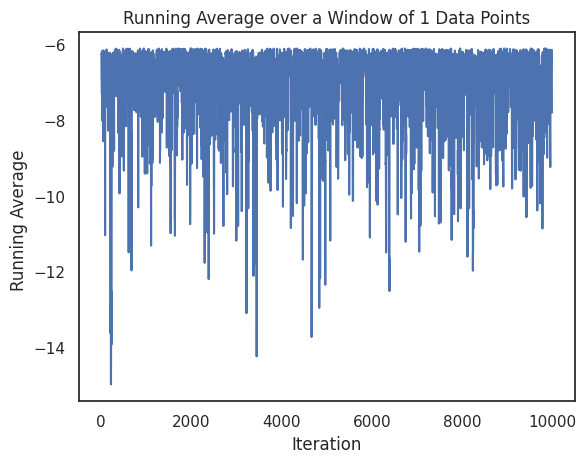

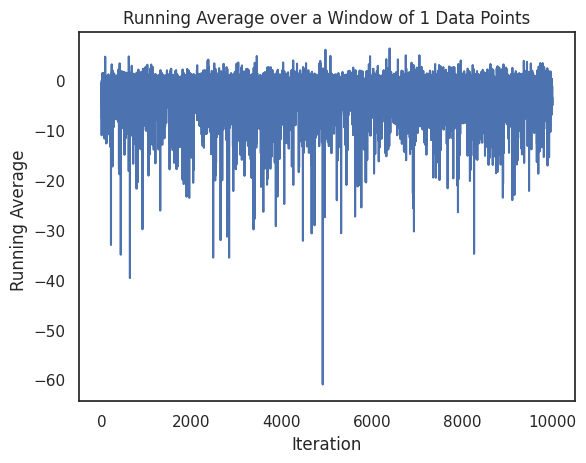

In [ ]:
stepsize_vanilla_bi = 1
lkhd_scaler_vanilla_bi = 0.0001
samples, accepted, acceptence_prob, lkhd, lkhd_diff = vanillaMH(data_bi, lkhd_bi, proposal_grw, initial_theta_bi, num_iterations_bi, stepsize_vanilla_bi, lkhd_scaler_vanilla_bi)
print("SUCCESFULLY RAN vanillaMH")

print(np.median(lkhd))
print(np.median(acceptence_prob))

plot_samples = create_sample(samples, burn_in_bi,c_bi)
print(sample_quality_score(plot_samples, true_theta_std))

plt_samples(plot_samples)

plot_running_average(accepted,50)

plot_running_average(lkhd, 1)

plot_running_average(lkhd_diff, 1)

### MALA

[0.00184217 0.00184217]
SUCCESFULLY RAN MALA
-0.616150575123133
4.887872019073811e-07
(0.7864456486495187, 0.49064058642349734)


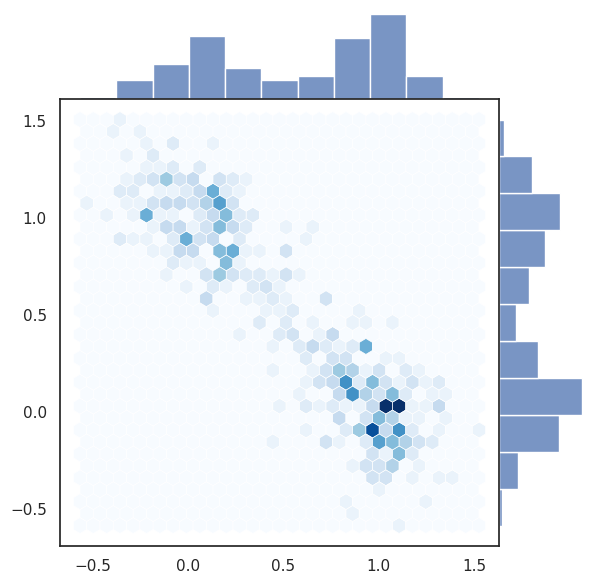

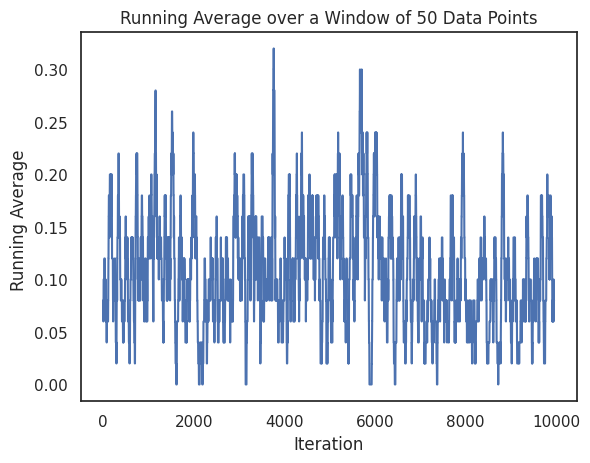

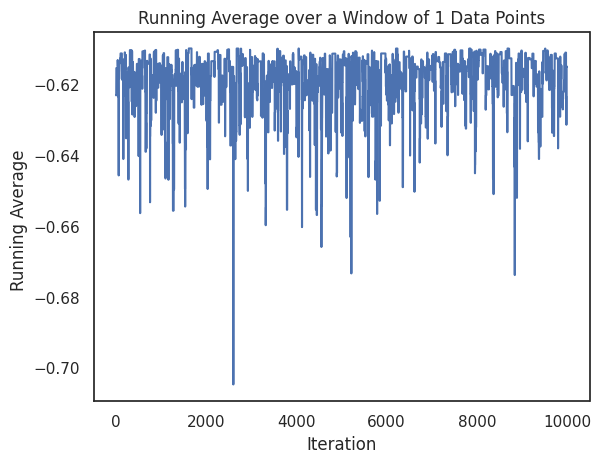

In [ ]:
stepsize_mala_bi = 1
samples, accepted, acceptence_prob, lkhd = mala(data_bi, lkhd_bi, proposal_langevin, initial_theta_bi, num_iterations_bi, stepsize_mala_bi, gradient_scaler_bi, lkhd_scaler_bi)
print("SUCCESFULLY RAN MALA")
print(np.median(lkhd))
print(np.median(acceptence_prob))

plot_samples = create_sample(samples, burn_in_std,c_std)
print(sample_quality_score(plot_samples, true_theta_std))

plt_samples(plot_samples)
plot_running_average(accepted, 50)
plot_running_average(lkhd, 1)

### ConsensunsMC

SUCCESFULLY RAN consensusMC
-30546.787190444877
0.43265096398058733
(0.7134989239766187, 0.007838545925746001)


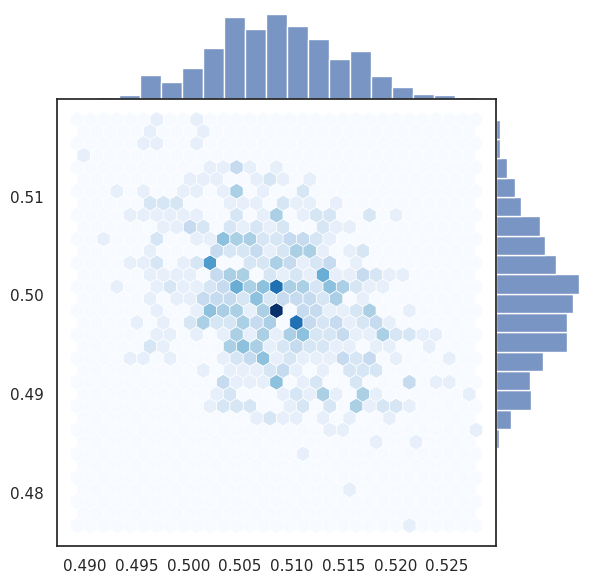

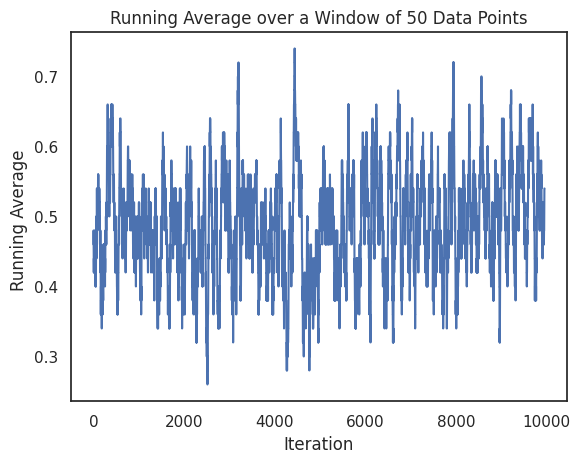

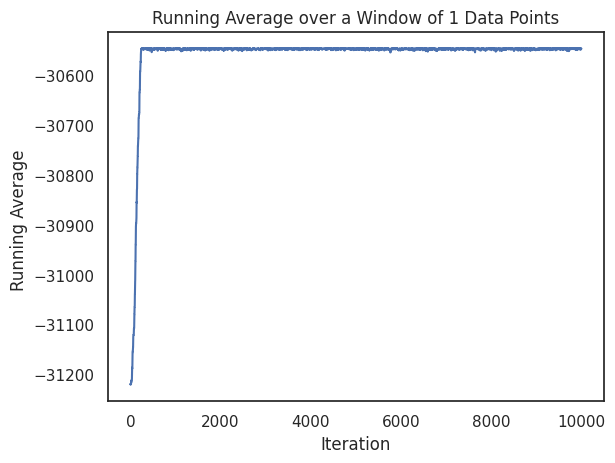

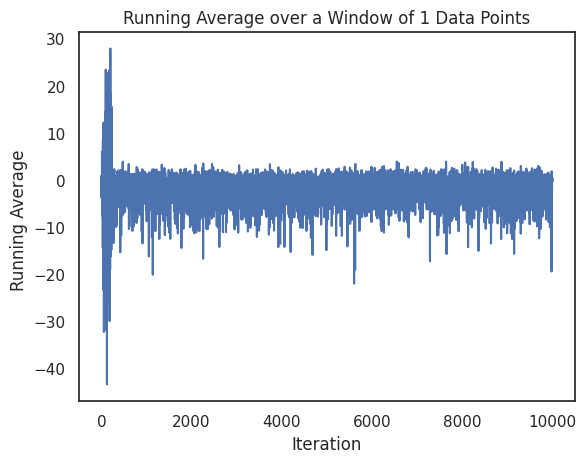

In [ ]:
stepsize_vanilla_bi = 0.01
num_batches_bi = 2
samples, accepted, acceptence_prob, lkhd, lkhd_diff = consensusMC(data_bi, lkhd_bi, proposal_grw, initial_theta_bi, num_iterations_bi, stepsize_vanilla_bi, num_batches_bi, lkhd_scaler_vanilla_bi)
print("SUCCESFULLY RAN consensusMC")

print(np.median(lkhd))
print(np.median(acceptence_prob))

plot_samples = create_sample(samples, burn_in_std,c_std)
print(sample_quality_score(plot_samples, true_theta_std))

plt_samples(plot_samples)

plot_running_average(accepted,50)

plot_running_average(lkhd, 1)

plot_running_average(lkhd_diff, 1)

### FireflyMC

### csMALA

SUCCESFULLY RAN csMALA
(0.7350642734378584, 0.4946372757264792)


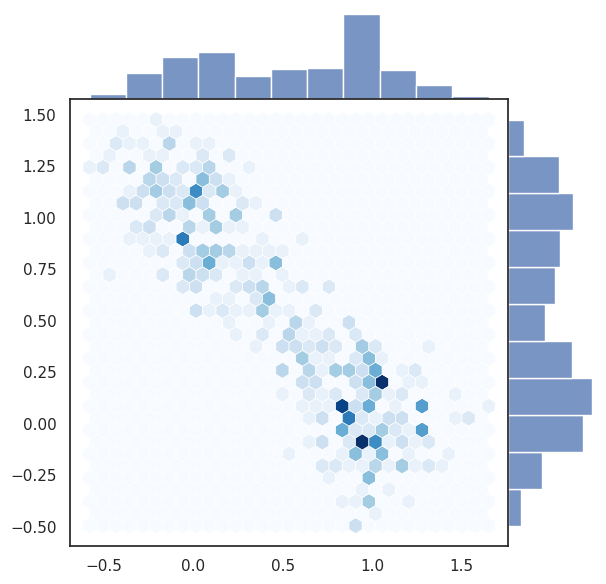

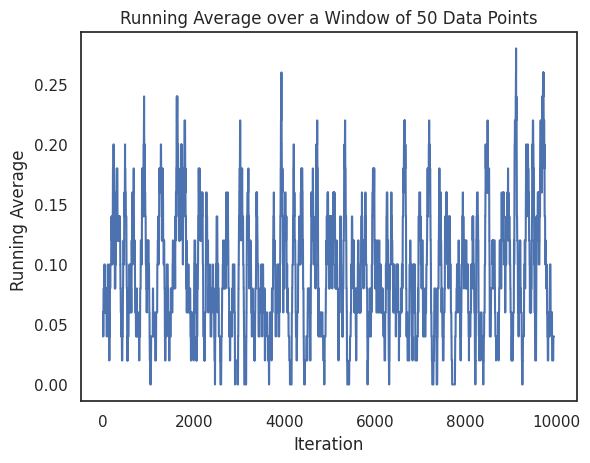

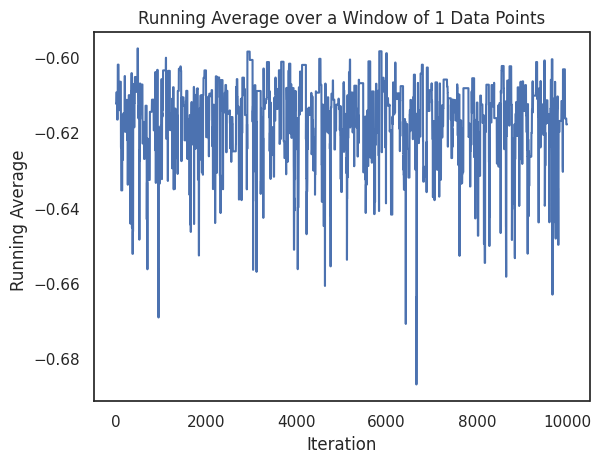

In [ ]:
correction_scaler_bi = 0.1
lkhd_scaler_csMALA_bi = data.size*0.001

samples, accepted, acceptence_prob, lkhd, lkhd_diff, corr_diff, prob_diff = csMALA(data_bi, lkhd_bi, proposal_langevin, initial_theta_bi, num_iterations_bi, stepsize_mala_bi, gradient_scaler_bi, subsampling_perc_bi, correction_scaler_bi,lkhd_scaler_csMALA_bi)
print("SUCCESFULLY RAN csMALA")
plot_samples = create_sample(samples, burn_in_std,c_std)
print(sample_quality_score(plot_samples, true_theta_std))

plt_samples(plot_samples)

plot_running_average(accepted,50)

plot_running_average(lkhd, 1)